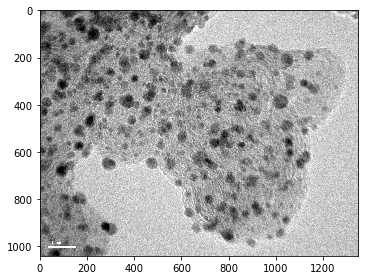

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
from skimage import data, io, filters, feature
# Load the TEM image
original_image = cv2.imread('tem4.tif', 0)
io.imshow(original_image)

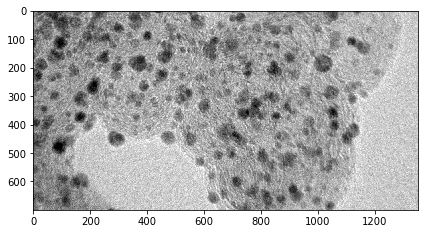

In [2]:
cropped_image = original_image[200:900, :]
io.imshow(cropped_image)

In [3]:
# Find the pixels
#height_pixels, width_pixels = image.shape[0], image.shape[1]
#pixels = image.shape[0] * image.shape[1]

# Fix the scale bar (assuming it's a white rectangle)
scale_bar_color = 255
scale_bar_height = 5 # height of the scale bar in pixels
scale_bar_width = 160 # width of the scale bar in pixels
cropped_image[-scale_bar_height:, :scale_bar_width] = scale_bar_color


In [4]:
# Calibrate the image (assuming the scale bar is in nanometers)
scale_bar_length_nm = 10 # length of the scale bar in nanometers
scale_bar_length_pixels = scale_bar_width # length of the scale bar in pixels
calibration_factor = scale_bar_length_nm / scale_bar_length_pixels

print(calibration_factor)

0.0625


In [ ]:
# Filter the image
filtered_image = cv2.GaussianBlur(cropped_image, (5, 5), 0)

# Process the image with FFT
f = np.fft.fft2(filtered_image)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift))


# Threshold the image
threshold = 80 # adjust threshold value as needed
ret, thresholded_image = cv2.threshold(filtered_image, threshold, 255, cv2.THRESH_BINARY)

# Show the processed images
plt.subplot(1, 3, 1), plt.imshow(cropped_image, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 3, 2), plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')

plt.subplot(1, 3, 3), plt.imshow(thresholded_image, cmap='gray')
plt.title('Thresholded Image')
plt.show()

In [ ]:
# Filter the image
filtered_image = cv2.GaussianBlur(cropped_image, (5, 5), 0)

# Process the image with FFT
f = np.fft.fft2(filtered_image)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift))


# Threshold the image
threshold = 90 # adjust threshold value as needed
ret, thresholded_image = cv2.threshold(filtered_image, threshold, 255, cv2.THRESH_BINARY)
io.imshow(thresholded_image)

In [ ]:
# Measure the length and area of particles

contours, hierarchy = cv2.findContours(thresholded_image, 1, 2)

#print(len(contours))

particles_data = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 0:
        contour_shape = contour.shape
        contour_2d = contour.reshape([contour_shape[0], contour_shape[2]]).transpose()
        contour_center = [np.average(contour_2d[0]), np.average(contour_2d[1])]
        length_x, lenght_y = (
            max(contour_2d[0]) - min(contour_2d[0])) * calibration_factor, (
                max(contour_2d[1]) - min(contour_2d[1])) * calibration_factor
        if length_x < 10 and lenght_y < 10 :
            length = cv2.arcLength(contour, True)
            particles_data.append({
                'Length (nm)': length * calibration_factor,
                'Area (pixels)': area
            })
            #print(area)


# Measure the length between dark spots
min_distance_between_spots = 2  # adjust minimum distance value as needed
lines_data = []
for i in range(len(contours)):   
    contour_shape_i = contours[i].shape
    contour_2d_i = contours[i].reshape([contour_shape_i[0], contour_shape_i[2]]).transpose()
    contour_center_i = [np.average(contour_2d_i[0]), np.average(contour_2d_i[1])]
    length_x_i, lenght_y_i = (
        max(contour_2d_i[0]) - min(contour_2d_i[0])) * calibration_factor, (
            max(contour_2d_i[1]) - min(contour_2d_i[1])) * calibration_factor      
    line_lengths = []
    for j in range(i + 1, len(contours)):  
        contour_shape_j = contours[j].shape
        contour_2d_j = contours[j].reshape([contour_shape_j[0], contour_shape_j[2]]).transpose()
        contour_center_j = [np.average(contour_2d_j[0]), np.average(contour_2d_j[1])]
        length_x_j, lenght_y_j = (
            max(contour_2d_j[0]) - min(contour_2d_j[0])) * calibration_factor, (
                max(contour_2d_j[1]) - min(contour_2d_j[1])) * calibration_factor  

        if length_x_i < 20 and lenght_y_i < 20 and length_x_j < 20 and lenght_y_j < 20:
        
            x1, y1 = tuple(contour_center_i)
            x2, y2 = tuple(contour_center_j)
            
            line_lengths.append(np.sqrt((x2 - x1)**2 + (y2 - y1)**2))
    if line_lengths:
        line_length = min(line_lengths)
        #print(line_length)
        lines_data.append(
            {'Length (nm)': line_length * calibration_factor})

        

In [ ]:
# Measure the length between neighboring particles
min_distance_between_spots = 2  # adjust minimum distance value as needed
lines_data = []
for i in range(len(contours)):
    contour_shape_i = contours[i].shape
    contour_2d_i = contours[i].reshape([contour_shape_i[0], contour_shape_i[2]]).transpose()
    contour_center_i = [np.average(contour_2d_i[0]), np.average(contour_2d_i[1])]
    length_x_i, length_y_i = (
        max(contour_2d_i[0]) - min(contour_2d_i[0])) * calibration_factor, (
            max(contour_2d_i[1]) - min(contour_2d_i[1])) * calibration_factor
    line_lengths = []
    for j in range(i + 1, len(contours)):
        contour_shape_j = contours[j].shape
        contour_2d_j = contours[j].reshape([contour_shape_j[0], contour_shape_j[2]]).transpose()
        contour_center_j = [np.average(contour_2d_j[0]), np.average(contour_2d_j[1])]
        length_x_j, length_y_j = (
            max(contour_2d_j[0]) - min(contour_2d_j[0])) * calibration_factor, (
                max(contour_2d_j[1]) - min(contour_2d_j[1])) * calibration_factor

        if length_x_i < 20 and length_y_i < 20 and length_x_j < 20 and length_y_j < 20:
            distance = np.sqrt((contour_center_j[0] - contour_center_i[0])**2 + (contour_center_j[1] - contour_center_i[1])**2)
            if distance < min_distance_between_spots:
                lines_data.append(
                    {'Length (nm)': distance})
 

In [ ]:
# Save the data in a CSV file
with open('TEM_data.csv', 'w', newline='') as csvfile:
    fieldnames = ['Length (nm)', 'Area (pixels)']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for particle_data in particles_data:
        writer.writerow(particle_data)
    for line_data in lines_data:
        writer.writerow(line_data)

# Plot the data in histogram
particle_lengths = [particle_data['Length (nm)'] for particle_data in particles_data]
plt.hist(particle_lengths, bins=20)
plt.xlabel('Length (nm)')
plt.ylabel('Frequency')
plt.title('TEM Particle Length Distribution')
plt.show()

# Show the processed images
plt.subplot(1, 3, 1), plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 3, 2), plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')
plt.subplot(1, 3, 3), plt.imshow(thresholded_image, cmap='gray')
plt.title('Thresholded Image')
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
from skimage import data, io, filters, feature
# Load the TEM image
image = cv2.imread('tem1.jpg', 0)



# Filter the image
filtered_image = cv2.bilateralFilter(image, 5, 75, 75)

# Perform FFT on the filtered image
f = np.fft.fft2(filtered_image)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift))

# Normalize the magnitude spectrum to [0, 255]
magnitude_spectrum = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Threshold the magnitude spectrum
_, thresholded_spectrum = cv2.threshold(magnitude_spectrum, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours in the thresholded spectrum
contours, _ = cv2.findContours(thresholded_spectrum, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw rectangles around the contours for particles
for contour in contours:
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(image, [box], 0, (0, 0, 255), 2)

# Extract black spot circles and measure their areas
_, thresholded_image = cv2.threshold(filtered_image, 0, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

extracted_circles = np.zeros_like(thresholded_image)

for contour in contours:
    (x, y), radius = cv2.minEnclosingCircle(contour)
    center = (int(x), int(y))
    radius = int(radius)
    cv2.circle(extracted_circles, center, radius, (255, 255, 255), cv2.FILLED)

# Display the extracted circles image
plt.imshow(extracted_circles, cmap='gray')
plt.title('Extracted Circles')
plt.show()

# Measure the areas of the extracted circles
contours, _ = cv2.findContours(extracted_circles, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
areas = []
for contour in contours:
    area = cv2.contourArea(contour)
    areas.append(area)

# Print the areas of the extracted circles
print('Areas of Extracted Circles:', areas)

# Save the areas in a CSV file
with open('areas.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Area'])
    writer.writerows(zip(areas))

# Plot the histogram of particle areas
plt.hist(areas, bins=10)
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Particle Size Distribution')
plt.show()

